In [31]:
import os
import json
import random
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from zipfile import ZipFile
from collections import Counter, OrderedDict
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras as keras

import fasttext
import spacy

%matplotlib inline

In [4]:
%%bash
python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [59]:
def read_file(fname):
    with open(fname, "r") as f:
        lines = f.readlines()

    x, y, unique_y = [[]], [[]], ["pad"]

    for line in lines:
        if line == "\n":
            x.append(list())
            y.append(list())
        else:
            split_y, split_x = line.lower().split("\t")
            x[-1].append(split_x.strip())
            y[-1].append(split_y.strip())
            
            if split_y.strip() not in unique_y:
                unique_y.append(split_y.split()[0])
            

    return x, y, sorted(unique_y)

In [155]:
# Read training data
x_trn, y_trn, categories = read_file("/kaggle/input/crisil/ner_train.txt")

print(f"Sample of training data of NER")
print(x_trn[:2])
print(y_trn[:2])

print(f"\nNumber of X and Y training records {len(x_trn)}, {len(y_trn)}\n")

print(f"Number of unique categories are {len(categories)}")
print(categories)

Sample of training data of NER
[['what', 'movies', 'star', 'bruce', 'willis'], ['show', 'me', 'films', 'with', 'drew', 'barrymore', 'from', 'the', '1980s']]
[['o', 'o', 'o', 'b-actor', 'i-actor'], ['o', 'o', 'o', 'o', 'b-actor', 'i-actor', 'o', 'o', 'b-year']]

Number of X and Y training records 9775, 9775

Number of unique categories are 26
['b-actor', 'b-character', 'b-director', 'b-genre', 'b-plot', 'b-rating', 'b-ratings_average', 'b-review', 'b-song', 'b-title', 'b-trailer', 'b-year', 'i-actor', 'i-character', 'i-director', 'i-genre', 'i-plot', 'i-rating', 'i-ratings_average', 'i-review', 'i-song', 'i-title', 'i-trailer', 'i-year', 'o', 'pad']


In [156]:
# Train and Validation data generation
x_trn, x_val, y_trn, y_val = train_test_split(x_trn, y_trn, test_size=0.20, random_state=42)

print(f"Number of X and Y training records {len(x_trn)}, {len(y_trn)}")
print(f"Number of X and Y validation records {len(x_val)}, {len(y_val)}\n")

print(f"Sample of training data of NER")
print(x_trn[:2])
print(y_trn[:2])

print(f"\nSample of validation data of NER")
print(x_val[:2])
print(y_val[:2])

Number of X and Y training records 7820, 7820
Number of X and Y validation records 1955, 1955

Sample of training data of NER
[['who', 'directed', 'the', 'goonies'], ['who', 'played', 'as', 'agent', 'smith', 'in', 'the', 'matrix']]
[['o', 'o', 'b-title', 'i-title'], ['o', 'o', 'o', 'b-character', 'i-character', 'o', 'b-title', 'i-title']]

Sample of validation data of NER
[['who', 'directed', 'laputa', 'castle', 'in', 'the', 'sky'], ['are', 'there', 'any', 'movies', 'about', 'the', 'navy', 'from', 'the', 'last', 'ten', 'years', 'that', 'are', 'rated', 'pg', '13']]
[['o', 'o', 'b-title', 'i-title', 'i-title', 'i-title', 'i-title'], ['o', 'o', 'o', 'o', 'o', 'o', 'b-plot', 'o', 'o', 'b-year', 'i-year', 'i-year', 'o', 'o', 'o', 'b-rating', 'i-rating']]


In [157]:
x_test, y_test, _ = read_file("/kaggle/input/crisil/ner_test.txt")

print(f"Sample of testing data of NER")
print(x_test[:2])
print(y_test[:2])

print(f"\nNumber of X and Y testing records {len(x_test)}, {len(y_test)}")

Sample of testing data of NER
[['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out', 'right', 'now'], ['show', 'me', 'a', 'movie', 'about', 'cars', 'that', 'talk']]
[['o', 'o', 'o', 'o', 'b-genre', 'i-genre', 'o', 'b-year', 'i-year'], ['o', 'o', 'o', 'o', 'o', 'b-plot', 'i-plot', 'i-plot']]

Number of X and Y testing records 2443, 2443


## EDA

In [23]:
# Build word cloud
def create_cloud(string, title=None):
    cloud = WordCloud(height=1080, 
                      width=1920, 
                      background_color='white', 
                      min_font_size=10, 
                      stopwords=STOPWORDS).generate(string)
    plt.figure(figsize=(15,30))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    if title:
        plt.title(title, fontdict={'fontsize':24})
    plt.show()

100%|██████████| 862M/862M [11:43<00:00, 1.22MiB/s]
100%|██████████| 2.44G/2.44G [06:47<00:00, 5.98MiB/s]


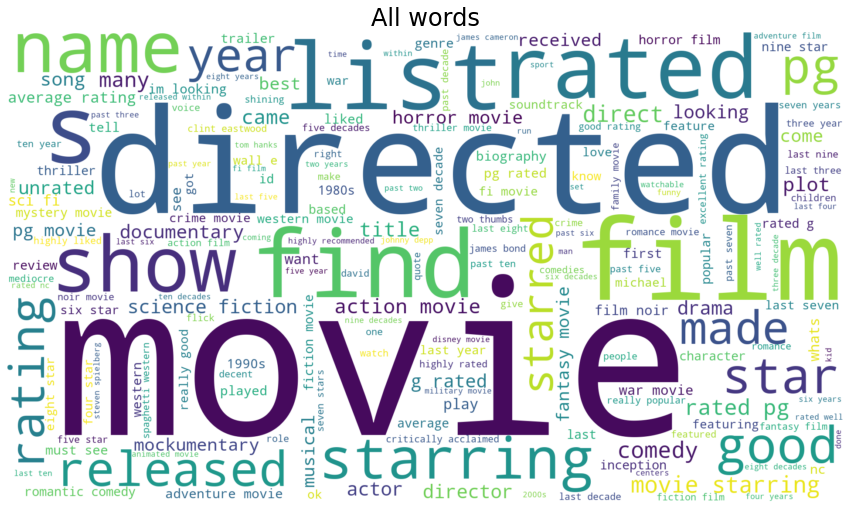

In [27]:
# Training data word cloud
create_cloud(' '.join(word for sent in x_trn for word in sent), "All words") 

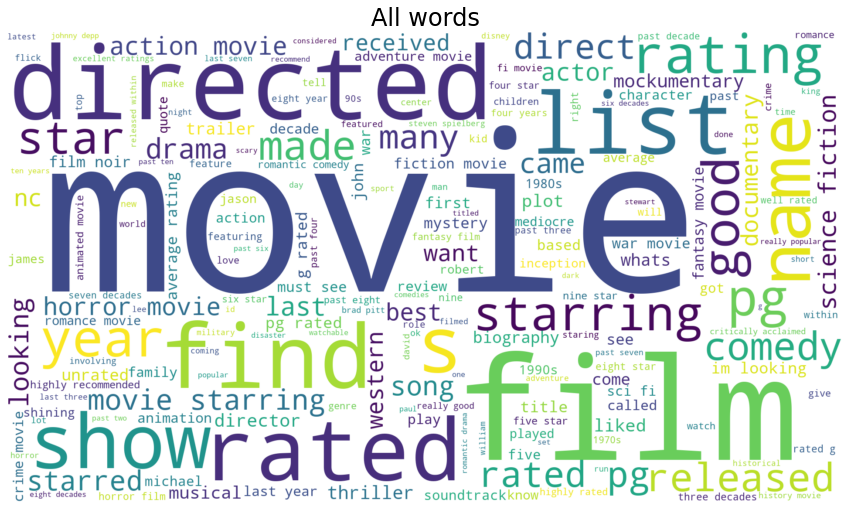

In [28]:
# Validation data word cloud
create_cloud(' '.join(word for sent in x_val for word in sent), "All words") 

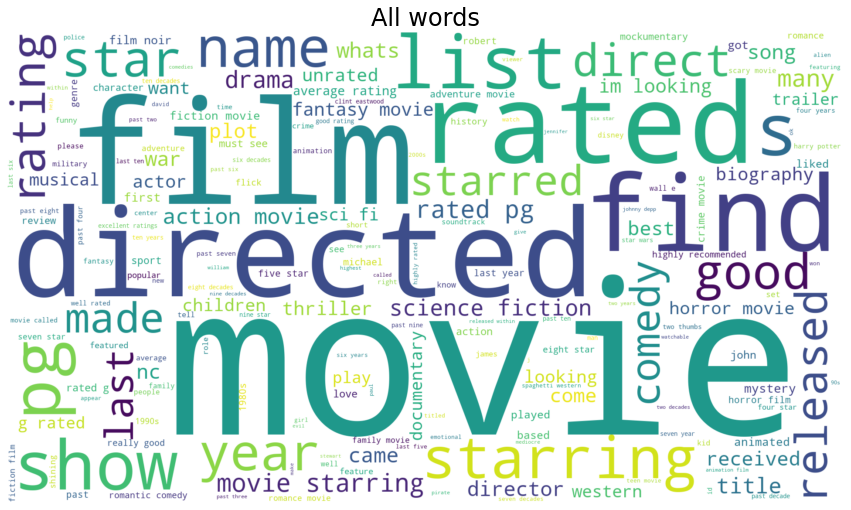

In [29]:
# Testing data word cloud
create_cloud(' '.join(word for sent in x_test for word in sent), "All words") 

In [45]:
def func(y):
    counts = OrderedDict(Counter([label for sent_output in y for label in sent_output]))
    # Setting 'o' label to zero for better visibility of labels counter
    counts['o'] = 0
    return counts.keys(), counts.values()

<BarContainer object of 25 artists>

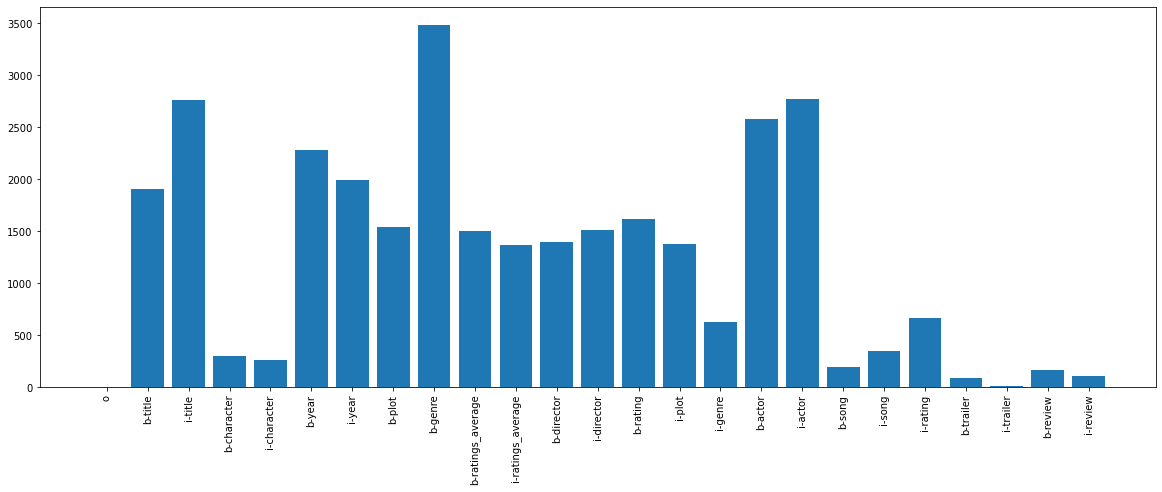

In [46]:
y_trn_keys, y_trn_values = func(y_trn)

plt.figure(figsize=(20,7))
plt.xticks(rotation=90)
plt.bar(y_trn_keys, y_trn_values)

<BarContainer object of 25 artists>

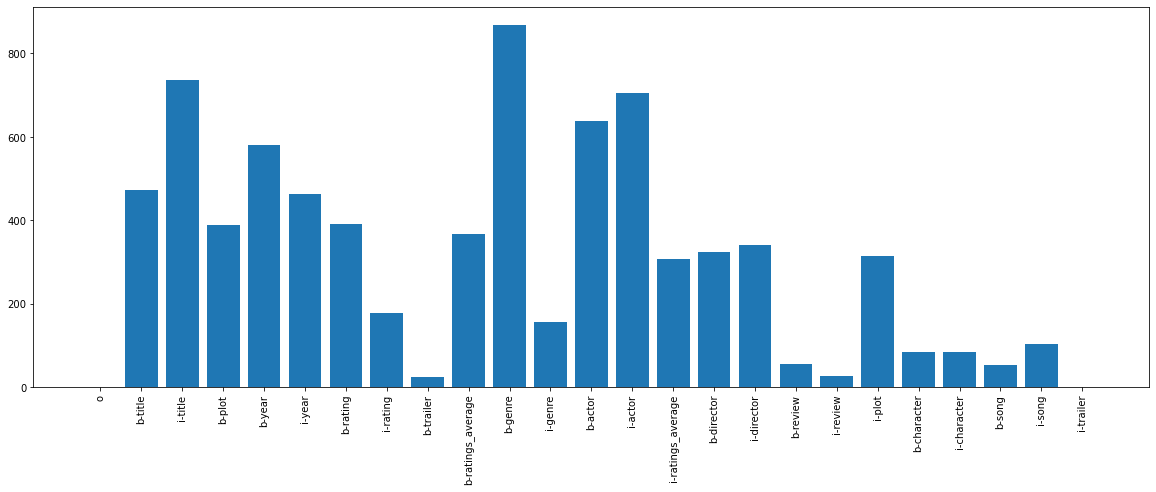

In [49]:
y_val_keys, y_val_values = func(y_val)

plt.figure(figsize=(20,7))
plt.xticks(rotation=90)
plt.bar(y_val_keys, y_val_values)

<BarContainer object of 25 artists>

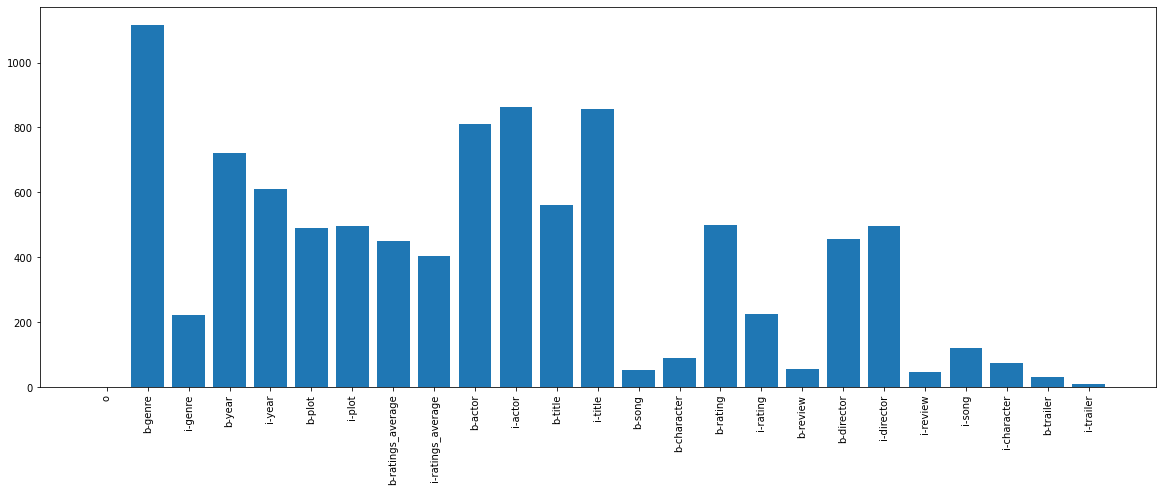

In [50]:
y_test_keys, y_test_values = func(y_test)

plt.figure(figsize=(20,7))
plt.xticks(rotation=90)
plt.bar(y_test_keys, y_test_values)

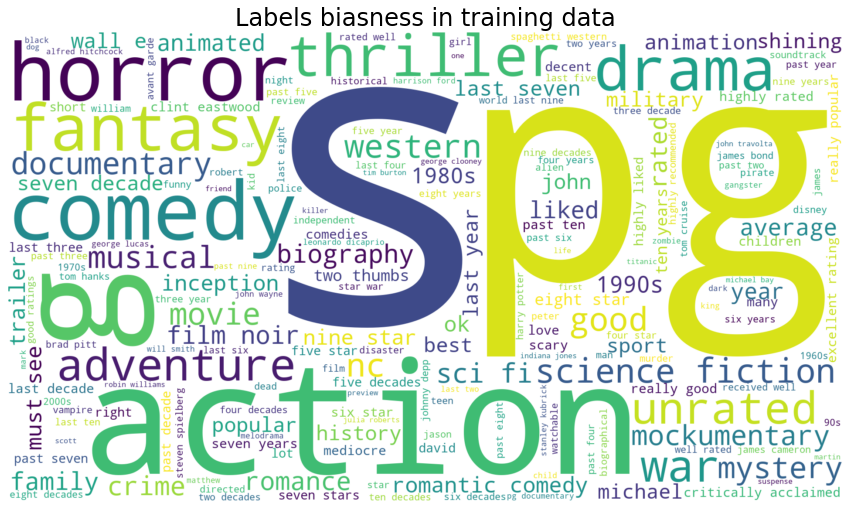

In [55]:
# Check if there is label biasness present in training data
create_cloud(' '.join([word if label != 'o' else '' for sent_in, sent_out in zip(x_trn, y_trn) for word, label in zip(sent_in, sent_out)]), "Labels biasness in training data")

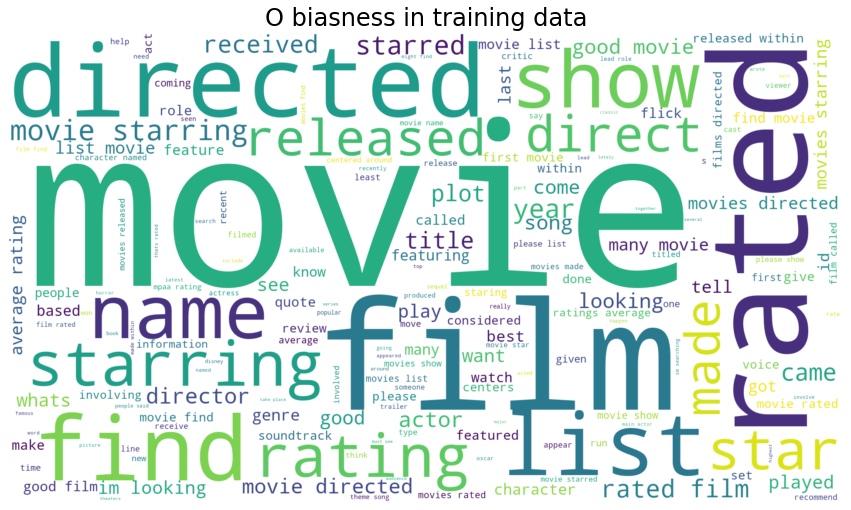

In [57]:
create_cloud(' '.join([word if label == 'o' else '' for sent_in, sent_out in zip(x_trn, y_trn) for word, label in zip(sent_in, sent_out)]), "O biasness in training data")

## Utils

In [13]:
def get_file(fname, url):
    fpath = os.path.join(os.getcwd(), fname)
    fdownloaded = False
    funzipped = False

    if not os.path.exists(fpath):
        try:
            print(f"Downloading {fname}...")
            response = requests.get(url, stream=True)

            total_size_in_bytes= int(response.headers.get("content-length", 0))
            block_size = 1024
            progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)

            with open(fpath, "wb") as f:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    f.write(data)
            
            if fname.endswith(".zip"):
                print(f"Extracting {fname}...")
                with ZipFile(fpath, "r") as f:
                    for file in tqdm(iterable=f.namelist(), total=len(f.namelist())):
                        f.extract(member=file)

        except Exception as e:
            print(f"Error in downloading or unzipping file check below error.\n {e}")

    return fpath, fdownloaded, funzipped

In [14]:
glove_fpath, glove_fdownloaded, glove_funzipped = get_file("glove.6B.zip", "http://nlp.stanford.edu/data/glove.6B.zip")

100%|█████████▉| 859M/862M [02:41<00:00, 4.76MiB/s] 
  0%|          | 0/4 [00:00<?, ?it/s]

Extracting glove.6B.zip...



 50%|█████     | 2/4 [00:04<00:05,  2.62s/it]
100%|██████████| 862M/862M [03:00<00:00, 4.76MiB/s]
100%|██████████| 4/4 [00:21<00:00,  5.26s/it]


In [15]:
# Quantized version of fasttext english word embeddings from 300 to 100 dimension
fasttext_fpath, fasttext_fdownloaded, fasttext_funzipped = get_file("cc.en.100.bin", 
                                                                "https://geniekalp.s3.ap-south-1.amazonaws.com/pretrained_embeddings/cc.en.100.bin")


  0%|          | 0.00/2.44G [00:00<?, ?iB/s]
  0%|          | 9.22k/2.44G [00:00<15:30:09, 43.7kiB/s]
  0%|          | 43.0k/2.44G [00:00<6:05:55, 111kiB/s]  
  0%|          | 94.2k/2.44G [00:00<3:59:53, 169kiB/s]
  0%|          | 200k/2.44G [00:00<2:17:02, 296kiB/s] 
  0%|          | 426k/2.44G [00:01<1:11:15, 570kiB/s]
  0%|          | 879k/2.44G [00:01<37:07, 1.09MiB/s] 
  0%|          | 1.78M/2.44G [00:01<19:12, 2.11MiB/s]
  0%|          | 3.58M/2.44G [00:01<09:52, 4.10MiB/s]
  0%|          | 5.48M/2.44G [00:01<07:15, 5.59MiB/s]
  0%|          | 7.33M/2.44G [00:02<06:12, 6.53MiB/s]
  0%|          | 9.38M/2.44G [00:02<05:27, 7.42MiB/s]
  0%|          | 11.2M/2.44G [00:02<05:16, 7.67MiB/s]
  1%|          | 13.2M/2.44G [00:02<04:52, 8.28MiB/s]
  1%|          | 15.0M/2.44G [00:03<04:53, 8.24MiB/s]
  1%|          | 17.1M/2.44G [00:03<04:38, 8.70MiB/s]
  1%|          | 18.8M/2.44G [00:03<04:43, 8.53MiB/s]
  1%|          | 20.8M/2.44G [00:03<04:35, 8.76MiB/s]
  1%|          | 22.6M/2.44G

 23%|██▎       | 572M/2.44G [01:00<02:31, 12.3MiB/s]
 24%|██▎       | 574M/2.44G [01:00<02:38, 11.7MiB/s]
 24%|██▎       | 575M/2.44G [01:00<02:55, 10.6MiB/s]
 24%|██▎       | 578M/2.44G [01:01<02:40, 11.6MiB/s]
 24%|██▍       | 581M/2.44G [01:01<02:14, 13.8MiB/s]
 24%|██▍       | 582M/2.44G [01:01<02:34, 12.0MiB/s]
 24%|██▍       | 584M/2.44G [01:01<02:47, 11.1MiB/s]
 24%|██▍       | 586M/2.44G [01:01<02:45, 11.2MiB/s]
 24%|██▍       | 588M/2.44G [01:01<02:11, 14.0MiB/s]
 24%|██▍       | 590M/2.44G [01:01<02:32, 12.1MiB/s]
 24%|██▍       | 591M/2.44G [01:02<02:44, 11.2MiB/s]
 24%|██▍       | 594M/2.44G [01:02<02:49, 10.9MiB/s]
 24%|██▍       | 596M/2.44G [01:02<02:07, 14.4MiB/s]
 25%|██▍       | 598M/2.44G [01:02<02:29, 12.3MiB/s]
 25%|██▍       | 600M/2.44G [01:02<02:37, 11.7MiB/s]
 25%|██▍       | 601M/2.44G [01:02<02:52, 10.6MiB/s]
 25%|██▍       | 604M/2.44G [01:03<02:37, 11.6MiB/s]
 25%|██▍       | 607M/2.44G [01:03<02:34, 11.8MiB/s]
 25%|██▌       | 609M/2.44G [01:03<02:34, 11.8

 51%|█████▏    | 1.25G/2.44G [02:00<01:50, 10.7MiB/s]
 51%|█████▏    | 1.25G/2.44G [02:00<01:50, 10.7MiB/s]
 52%|█████▏    | 1.26G/2.44G [02:01<01:51, 10.6MiB/s]
 52%|█████▏    | 1.26G/2.44G [02:01<01:50, 10.7MiB/s]
 52%|█████▏    | 1.26G/2.44G [02:01<01:48, 10.8MiB/s]
 52%|█████▏    | 1.26G/2.44G [02:01<01:50, 10.6MiB/s]
 52%|█████▏    | 1.27G/2.44G [02:01<01:48, 10.7MiB/s]
 52%|█████▏    | 1.27G/2.44G [02:02<01:48, 10.8MiB/s]
 52%|█████▏    | 1.27G/2.44G [02:02<01:48, 10.8MiB/s]
 52%|█████▏    | 1.27G/2.44G [02:02<01:47, 10.8MiB/s]
 52%|█████▏    | 1.28G/2.44G [02:02<01:47, 10.8MiB/s]
 52%|█████▏    | 1.28G/2.44G [02:02<01:50, 10.5MiB/s]
 53%|█████▎    | 1.28G/2.44G [02:03<01:48, 10.7MiB/s]
 53%|█████▎    | 1.28G/2.44G [02:03<01:45, 10.9MiB/s]
 53%|█████▎    | 1.28G/2.44G [02:03<01:47, 10.8MiB/s]
 53%|█████▎    | 1.29G/2.44G [02:03<01:48, 10.6MiB/s]
 53%|█████▎    | 1.29G/2.44G [02:04<01:45, 10.8MiB/s]
 53%|█████▎    | 1.29G/2.44G [02:04<01:48, 10.6MiB/s]
 53%|█████▎    | 1.29G/2.44G

 79%|███████▊  | 1.92G/2.44G [03:02<00:48, 10.7MiB/s]
 79%|███████▉  | 1.92G/2.44G [03:02<00:45, 11.2MiB/s]
 79%|███████▉  | 1.92G/2.44G [03:02<00:46, 11.0MiB/s]
 79%|███████▉  | 1.93G/2.44G [03:02<00:45, 11.3MiB/s]
 79%|███████▉  | 1.93G/2.44G [03:02<00:45, 11.1MiB/s]
 79%|███████▉  | 1.93G/2.44G [03:03<00:44, 11.3MiB/s]
 79%|███████▉  | 1.93G/2.44G [03:03<00:45, 11.2MiB/s]
 79%|███████▉  | 1.93G/2.44G [03:03<00:44, 11.3MiB/s]
 79%|███████▉  | 1.94G/2.44G [03:03<00:45, 10.9MiB/s]
 80%|███████▉  | 1.94G/2.44G [03:04<00:44, 11.2MiB/s]
 80%|███████▉  | 1.94G/2.44G [03:04<00:46, 10.7MiB/s]
 80%|███████▉  | 1.94G/2.44G [03:04<00:41, 12.0MiB/s]
 80%|███████▉  | 1.94G/2.44G [03:04<00:43, 11.2MiB/s]
 80%|███████▉  | 1.95G/2.44G [03:04<00:50, 9.82MiB/s]
 80%|███████▉  | 1.95G/2.44G [03:04<00:39, 12.4MiB/s]
 80%|███████▉  | 1.95G/2.44G [03:05<00:47, 10.2MiB/s]
 80%|████████  | 1.95G/2.44G [03:05<00:49, 9.85MiB/s]
 80%|████████  | 1.95G/2.44G [03:05<00:52, 9.25MiB/s]
 80%|████████  | 1.95G/2.44G

In [17]:
# Load glove embedding which provides us embedding matrix and its word to id mapping and vice versa
def load_glove(fpath, dim):
    with open(fpath, "r") as f:
        lines = f.readlines()

    matrix = np.zeros((len(lines), dim))
    id2word = dict()
    word2id = dict()

    for idx, line in enumerate(lines):
        line_split = line.split()
        word = line_split[0]

        matrix[idx] = line_split[1:]

        id2word[idx] = word
        word2id[word] = idx

    return matrix, id2word, word2id

glove_matrix, glove_id2word, glove_word2id = load_glove("glove.6B.100d.txt", 100)

print(f"Shape of matrix is {glove_matrix.shape}\n")
print(f"Cross checking word2id and id2word contains same number of records. word2id are {len(glove_word2id.keys())} and \
id2word are {len(glove_id2word.keys())}")

Shape of matrix is (400000, 100)

Cross checking word2id and id2word contains same number of records. word2id are 400000 and id2word are 400000


In [18]:
# Checking unk and pad word is present in glove pretrained model
print(f"pad word is {'present' if glove_word2id.get('pad') else 'not present'}")
print(f"unk word is {'present' if glove_word2id.get('unk') else 'not present'}")

pad word is present
unk word is present


In [19]:
print(f"Word2id of india in glove embedding is = {glove_word2id.get('india')}")

Word2id of india in glove embedding is = 474


In [20]:
print(f"Id2word of india in glove embedding is at 474 or not = {glove_id2word.get(474)}")

Id2word of india in glove embedding is at 474 or not = india


In [21]:
# Load fasttext embedding which provides object that has various functionality in it
def load_fasttext(fpath):
    fasttext_model = fasttext.load_model(fpath)
    
    return fasttext_model

fasttext_model = load_fasttext(fasttext_fpath)

In [22]:
# Checking unk and pad word is present in glove pretrained model
print(f"pad word is {'present' if fasttext_model.get_word_id('pad') else 'not present'}")
print(f"unk word is {'present' if fasttext_model.get_word_id('unk') else 'not present'}")

pad word is present
unk word is present


In [58]:
spacy_nlp = spacy.load('en_core_web_sm')

In [67]:
# Category to id mapping and vice versa
cat2id = {k:i for i, k in enumerate(categories)}
id2cat = {i:k for i, k in enumerate(categories)}

print(f"cat2id: {cat2id}\n")
print(f"id2cat: {id2cat}")

cat2id: {'b-actor': 0, 'b-character': 1, 'b-director': 2, 'b-genre': 3, 'b-plot': 4, 'b-rating': 5, 'b-ratings_average': 6, 'b-review': 7, 'b-song': 8, 'b-title': 9, 'b-trailer': 10, 'b-year': 11, 'i-actor': 12, 'i-character': 13, 'i-director': 14, 'i-genre': 15, 'i-plot': 16, 'i-rating': 17, 'i-ratings_average': 18, 'i-review': 19, 'i-song': 20, 'i-title': 21, 'i-trailer': 22, 'i-year': 23, 'o': 24, 'pad': 25}

id2cat: {0: 'b-actor', 1: 'b-character', 2: 'b-director', 3: 'b-genre', 4: 'b-plot', 5: 'b-rating', 6: 'b-ratings_average', 7: 'b-review', 8: 'b-song', 9: 'b-title', 10: 'b-trailer', 11: 'b-year', 12: 'i-actor', 13: 'i-character', 14: 'i-director', 15: 'i-genre', 16: 'i-plot', 17: 'i-rating', 18: 'i-ratings_average', 19: 'i-review', 20: 'i-song', 21: 'i-title', 22: 'i-trailer', 23: 'i-year', 24: 'o', 25: 'pad'}


## BiLSTM with Glove

#### Prepare input data

In [140]:
def glove_generator(word2id, cat2id, x, y, maxlen, categories):
    x_vector, y_vector = [], []
    
    x = keras.preprocessing.sequence.pad_sequences(sequences=x, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    y = keras.preprocessing.sequence.pad_sequences(sequences=y, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    
    for X, Y in zip(x, y):
        tmp_x = []
        tmp_y = []
        for word, label in zip(X, Y):
            tmp_x.append(word2id.get(word, word2id.get("unk")))
            tmp_y.append(keras.utils.to_categorical(cat2id.get(label), len(categories)))

        x_vector.append(tmp_x)
        y_vector.append(tmp_y)

    return np.array(x_vector), np.array(y_vector)

In [141]:
x_trn, y_trn = glove_generator(glove_word2id, cat2id, x_trn, y_trn, 50, categories)
x_val, y_val = glove_generator(glove_word2id, cat2id, x_val, y_val, 50, categories)
x_test, y_test = glove_generator(glove_word2id, cat2id, x_test, y_test, 50, categories)

#### Neural network

In [125]:
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1_val

def seq_acc(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    
    return tf.reduce_mean(squared_difference, axis=-1)

In [146]:
def lstm_base_model(matrix, categories, maxlen):
    
    input_layer = keras.Input(shape=(maxlen,))
    embedding_layer = keras.layers.Embedding(400000, 100, weights=[matrix], input_length=maxlen, trainable=False)(input_layer)
    bi_lstm_layer = keras.layers.Bidirectional(keras.layers.LSTM(maxlen, return_sequences=True))(embedding_layer)
    dense_layer = keras.layers.Dense(len(categories), activation="softmax")(bi_lstm_layer)
    
    model = keras.Model(input_layer, dense_layer)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
    
    return model

In [147]:
glove_lstm_base_model = lstm_base_model(glove_matrix, categories, 50)
glove_lstm_base_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 50, 100)           40000000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 100)           60400     
_________________________________________________________________
dense_4 (Dense)              (None, 50, 26)            2626      
Total params: 40,063,026
Trainable params: 63,026
Non-trainable params: 40,000,000
_________________________________________________________________


In [148]:
checkpoints = keras.callbacks.ModelCheckpoint("best_glove_model.hdf5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

batch_size = 64
epochs = 10
verbose = 1
training_records = x_trn.shape[0]

glove_lstm_base_model_history = glove_lstm_base_model.fit(x_trn, y_trn, batch_size=batch_size, epochs=epochs, verbose=verbose, 
                                                          callbacks=[checkpoints], validation_data=(x_val, y_val), 
                                                          steps_per_epoch=training_records//batch_size)

Epoch 1/10
122/122 [==============================] - 11s 68ms/step - loss: 0.9262 - accuracy: 0.8260 - val_loss: 0.2960 - val_accuracy: 0.9214

Epoch 00001: val_accuracy improved from -inf to 0.92141, saving model to best_glove_model.hdf5
Epoch 2/10
122/122 [==============================] - 7s 59ms/step - loss: 0.2693 - accuracy: 0.9266 - val_loss: 0.2027 - val_accuracy: 0.9494

Epoch 00002: val_accuracy improved from 0.92141 to 0.94937, saving model to best_glove_model.hdf5
Epoch 3/10
122/122 [==============================] - 7s 58ms/step - loss: 0.1818 - accuracy: 0.9538 - val_loss: 0.1503 - val_accuracy: 0.9629

Epoch 00003: val_accuracy improved from 0.94937 to 0.96293, saving model to best_glove_model.hdf5
Epoch 4/10
122/122 [==============================] - 7s 61ms/step - loss: 0.1354 - accuracy: 0.9654 - val_loss: 0.1237 - val_accuracy: 0.9680

Epoch 00004: val_accuracy improved from 0.96293 to 0.96797, saving model to best_glove_model.hdf5
Epoch 5/10
122/122 [==============

## BiLSTM with Fasttext

#### Prepare input data

In [160]:
def fasttext_generator(fasttext_obj, cat2id, x, y, maxlen, categories):
    x_vector, y_vector = [], []
    
    x = keras.preprocessing.sequence.pad_sequences(sequences=x, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    y = keras.preprocessing.sequence.pad_sequences(sequences=y, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    
    for X, Y in zip(x, y):
        tmp_x = []
        tmp_y = []
        for word, label in zip(X, Y):
            tmp_x.append(fasttext_obj.get_word_vector(word))
            tmp_y.append(keras.utils.to_categorical(cat2id.get(label), len(categories)))

        x_vector.append(tmp_x)
        y_vector.append(tmp_y)

    return np.array(x_vector), np.array(y_vector)

In [161]:
x_trn, y_trn = fasttext_generator(fasttext_model, cat2id, x_trn, y_trn, 50, categories)
x_val, y_val = fasttext_generator(fasttext_model, cat2id, x_val, y_val, 50, categories)
x_test, y_test = fasttext_generator(fasttext_model, cat2id, x_test, y_test, 50, categories)

#### Neural network

In [163]:
def fasttext_lstm_base_model(matrix, categories, maxlen):
    
    input_layer = keras.Input(shape=(maxlen, 100))
    bi_lstm_layer = keras.layers.Bidirectional(keras.layers.LSTM(maxlen, return_sequences=True))(input_layer)
    dense_layer = keras.layers.Dense(len(categories), activation="softmax")(bi_lstm_layer)
    
    model = keras.Model(input_layer, dense_layer)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
    
    return model

In [164]:
fasttext_lstm_base_model = fasttext_lstm_base_model(glove_matrix, categories, 50)
fasttext_lstm_base_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 50, 100)]         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 100)           60400     
_________________________________________________________________
dense_5 (Dense)              (None, 50, 26)            2626      
Total params: 63,026
Trainable params: 63,026
Non-trainable params: 0
_________________________________________________________________


In [165]:
checkpoints = keras.callbacks.ModelCheckpoint("best_glove_model.hdf5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

batch_size = 64
epochs = 10
verbose = 1
training_records = x_trn.shape[0]

fasttext_lstm_base_model_history = fasttext_lstm_base_model.fit(x_trn, y_trn, batch_size=batch_size, epochs=epochs, verbose=verbose, 
                                                          callbacks=[checkpoints], validation_data=(x_val, y_val), 
                                                          steps_per_epoch=training_records//batch_size)

Epoch 1/10
122/122 [==============================] - 11s 67ms/step - loss: 1.1778 - accuracy: 0.7766 - val_loss: 0.3680 - val_accuracy: 0.9210

Epoch 00001: val_accuracy improved from -inf to 0.92096, saving model to best_glove_model.hdf5
Epoch 2/10
122/122 [==============================] - 7s 59ms/step - loss: 0.3515 - accuracy: 0.9213 - val_loss: 0.3155 - val_accuracy: 0.9215

Epoch 00002: val_accuracy improved from 0.92096 to 0.92154, saving model to best_glove_model.hdf5
Epoch 3/10
122/122 [==============================] - 8s 62ms/step - loss: 0.3023 - accuracy: 0.9225 - val_loss: 0.2626 - val_accuracy: 0.9303

Epoch 00003: val_accuracy improved from 0.92154 to 0.93034, saving model to best_glove_model.hdf5
Epoch 4/10
122/122 [==============================] - 7s 59ms/step - loss: 0.2467 - accuracy: 0.9343 - val_loss: 0.2164 - val_accuracy: 0.9431

Epoch 00004: val_accuracy improved from 0.93034 to 0.94310, saving model to best_glove_model.hdf5
Epoch 5/10
122/122 [==============